## Pytesseract

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 20 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (17.9 MB/s)
debconf: unable to initia

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import cv2
import re
from glob import glob
from tqdm import tqdm
from tabulate import tabulate
from google.colab.patches import cv2_imshow
from sklearn.cluster import AgglomerativeClustering

print(f"OpenCV version: {cv2.__version__}")

OpenCV version: 4.6.0


In [8]:
images = glob('data/*.png')
images

['data/Rent_Report_Graphic__-_August_2022_2.width-720.png',
 'data/Rent_Report_-_October_2020.width-720.png',
 'data/Rent_Report_-_July_2020.width-720-1.png',
 'data/Rent_Report_-_October_2019.width-720.png',
 'data/Rent_Report_-_August_2021.width-720.png',
 'data/Rent_Report_-_March_2022.width-720.png',
 'data/Rent_Report_-_December_2019.width-720.png',
 'data/Rent_Report_-_April_2020.width-720-469x1024.png',
 'data/Rent_Report_-_December_2021.width-720.png',
 'data/Rent_Report_-_January_2021_2.width-720.png',
 'data/Rent_Report_-_September_2020.width-720.png',
 'data/Rent_Report_-December_2020_1.width-720.png',
 'data/Rent_Report_-_April_2022.width-720.png',
 'data/rent_report_-_november_2021.width-720.png',
 'data/Rent_Report_Infographic_10.width-720-483x1024.png',
 'data/Final_March-rent_Report-rankings-483x1024.png',
 'data/Rent_Report_Graphic_template_-_June_2022.width-720.png',
 'data/Rent_Report_-_May_2020.width-720-1-439x1024.png',
 'data/Rent_Report_-_May_2022_.width-720.png'

In [9]:
# Preprocessing parameters
preprocess_args = {
        "resize": 1100,
        "grayscale": True,
        "thresholding": "binary",
        "thresh_value": 160
}

In [10]:
def preprocess(image,
               resize = False,
               preserve_ar = False,
               grayscale = False,
               gaussian_blur = False,
               thresholding = False,
               thresh_value = 127,
               verbose = True):
  '''
  Preprocess image object input with:
  image: image input file path;
  resize: Resize to desired width and height dimensions. Takes arguments tuple
    (width, height), single Integer as target width or false boolean. Will
    inforce aspect ratio based on passed target width if preserve_ar argument is
    set to True. Default = False. Default = True if resize argument is integer;
  preserve_ar: Boolean argument to preserve original image's Aspect Ratio or
    redefine based on 'resize' input. Default = True;
  grayscale: OpenCV grayscaling. Takes argument boolean = True or False.
    Default = False;
  gaussian_blur: Smooth image input with a gaussian blurring method. Takes
    arguments Integer kernel size or false boolean. Default = False;
  thresholding: OpenCV simple thresholding. Takes arguments [binary, binary_inv]
    or false boolean. Default = False;
  thresh_value: OpenCV threshold value. Takes argument Int. Default = 127;
  '''
  # Image load and input dimensions
  input_file = image
  image = cv2.imread(image)
  input_height = int(image.shape[0])
  input_width = int(image.shape[1])
  aspect_ratio = input_height/input_width
  
  if verbose:
    print(f"Processing input file: {input_file}...")

  # Resizing
  if type(resize) == int:
    resize = (resize,)
    preserve_ar = True

  if resize:
    if preserve_ar:
      image = cv2.resize(image, (resize[0], int(resize[0]*aspect_ratio)))
    else:
      image = cv2.resize(image, resize)
  
  output_height = int(image.shape[0])
  output_width = int(image.shape[1])

  # Gray-scaling
  if grayscale:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Blurring
  if gaussian_blur:
    image = cv2.GaussianBlur(image, (5, 5), gaussian_blur)

  # Thresholding
  if thresholding:
    if thresholding == "binary":
      image = cv2.threshold(image, thresh_value, 255, cv2.THRESH_BINARY_INV)[1]
    elif thresholding == "binary_inv":
      image = cv2.threshold(image, thresh_value, 255, cv2.THRESH_BINARY_INV)[1]
    else:
      print("Invalid thresholding argument!")
  
  if verbose:
    print(f"Image input dimensions: {(input_width, input_height)}\n"\
          f"Image output dimensions: {(output_width, output_height)}\n")
  return image

In [ ]:
'''
get top left coordinate
get height and width

compare horizontal distance and store diff
  h_gap = x1 - (x0 + w0)
  # if h_gap is higher than a threshold, it means that text1 is in a new column

compare vertical distance and store diff
  v_gap = y1 - (y0 + h0)
  # If v_gap is positive, it means that text1 is in a new line

store coordinate when a big gap is found

'''

In [223]:
def draw_table(image):
  OCRdict = pytesseract.image_to_data(image,
                                      lang = 'eng',
                                      output_type = pytesseract.Output.DICT)
  
  # Initializing coords, gaps, and OCR text list
  coords = []
  h_gaps = []
  v_gaps = []
  OCRtext = []
  confs = []

  # Flags to manage text and table content
  within_table = 0

  for i in range(0, len(OCRdict["text"])):
    # Retrieving current text and coordinates
    x0 = OCRdict["left"][i]
    y0 = OCRdict["top"][i]
    w0 = OCRdict["width"][i]
    h0 = OCRdict["height"][i]
    text0 = OCRdict["text"][i]
    conf0 = OCRdict["conf"][i]

    # Retrieving following text and coordinates
    try:
      x1 = OCRdict["left"][i+1]
      y1 = OCRdict["top"][i+1]
      w1 = OCRdict["width"][i+1]
      h1 = OCRdict["height"][i+1]
      text1 = OCRdict["text"][i+1]
    except:
      pass
    
    # Calculating vertical and horizontal gaps
    h_gap = x1 - (x0 + w0)
    v_gap = y1 - (y0 + h0)

    # Initializing table on header first column 'rank'
    if "RANK" in text0:
      within_table = 1
    
    if "CITY" in text0:
      within_table = 1

    # Ending table on 'grand total'
    if ("grand" in text0.lower()) and ("total" in text1.lower()):
      within_table = 0

    # Ending table on 'average'
    if "average" in text0.lower():
      within_table = 0

    if within_table and (h0 < image.shape[0]/2) and (w0 < image.shape[1]/2):
      coords.append((x0, y0, w0, h0))
      h_gaps.append(h_gap)
      v_gaps.append(v_gap)
      OCRtext.append(text0)
      confs.append(conf0)

  return coords, h_gaps, v_gaps, OCRtext, confs

In [374]:
# problematic cases: 0, 3, ...
preprocessed = preprocess(images[23],
                          resize = preprocess_args['resize'],
                          grayscale = preprocess_args['grayscale'],
                          thresholding = preprocess_args['thresholding'],
                          thresh_value = preprocess_args['thresh_value'])

coords, h_gaps, v_gaps, OCRtext, confs = draw_table(preprocessed)

Processing input file: data/Rent_Report_-_August_2020.width-720.png...
Image input dimensions: (720, 1632)
Image output dimensions: (1100, 2493)



In [363]:
### Testing unit ###
test = pytesseract.image_to_data(preprocessed,
                          lang = 'eng',
                          output_type = pytesseract.Output.DICT)
### Testing unit ###

In [375]:
for c, h, v, t, conf in zip(coords, h_gaps, v_gaps, OCRtext, confs):
  print(f"coords: {c}\t h_gap: {h}\t v_gap: {v}\t text: {t}\t conf:{conf}")

coords: (45, 675, 55, 13)	 h_gap: 35	 v_gap: -13	 text: RANK	 conf:95
coords: (135, 675, 40, 13)	 h_gap: 4	 v_gap: -13	 text: CITY	 conf:31
coords: (179, 675, 7, 13)	 h_gap: 4	 v_gap: -13	 text: /	 conf:87
coords: (190, 675, 48, 13)	 h_gap: 173	 v_gap: -13	 text: AREA	 conf:95
coords: (411, 675, 8, 13)	 h_gap: 107	 v_gap: -13	 text: 41	 conf:64
coords: (526, 675, 37, 13)	 h_gap: 68	 v_gap: -13	 text: MM	 conf:64
coords: (631, 675, 30, 13)	 h_gap: 109	 v_gap: -13	 text: vy	 conf:44
coords: (770, 675, 51, 13)	 h_gap: 63	 v_gap: -13	 text: 2BED	 conf:75
coords: (884, 675, 36, 13)	 h_gap: 66	 v_gap: -13	 text: MM	 conf:27
coords: (986, 675, 30, 13)	 h_gap: -978	 v_gap: 27	 text: vv	 conf:47
coords: (38, 715, 33, 34)	 h_gap: 64	 v_gap: -25	 text: ®	 conf:43
coords: (135, 724, 82, 19)	 h_gap: 7	 v_gap: -19	 text: Toronto,	 conf:95
coords: (224, 724, 31, 17)	 h_gap: 156	 v_gap: -20	 text: ON	 conf:96
coords: (411, 721, 73, 20)	 h_gap: 43	 v_gap: -18	 text: $2,051	 conf:48
coords: (527, 723, 5

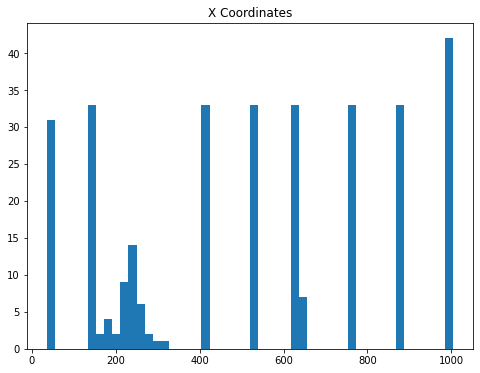

In [376]:
# X coordinates are good for clustering to define number of columns
plt.figure(figsize = (8, 6))
plt.title("X Coordinates")
plt.hist([x[0] for x in coords], bins = 50)
plt.show()

In [377]:
x_coords = [(x[0], 0) for x in coords]

clustering = AgglomerativeClustering(n_clusters = None,
                                     affinity = "manhattan",
                                     linkage = "complete",
                                     distance_threshold = 3)
clustering.fit(x_coords)

AgglomerativeClustering(affinity='manhattan', distance_threshold=3,
                        linkage='complete', n_clusters=None)

In [378]:
v_lines = []
h_padding = 10

for cluster in np.unique(clustering.labels_):
  ids = np.where(clustering.labels_ == cluster)[0]
  
  if len(ids) > 10:
    avg_x = np.average([coords[i][0] for i in ids])
    v_lines.append(int(avg_x) - h_padding)

v_lines.sort()
n_columns = len(v_lines)
v_lines

[27, 125, 401, 516, 623, 760, 874, 977]

In [379]:
y_coords = [(0, y[1]) for y in coords]

clustering = AgglomerativeClustering(n_clusters = None,
                                     affinity = "manhattan",
                                     linkage = "complete",
                                     distance_threshold = 6)
clustering.fit(y_coords)

AgglomerativeClustering(affinity='manhattan', distance_threshold=6,
                        linkage='complete', n_clusters=None)

In [380]:
h_lines = []
v_padding = 10

for cluster in np.unique(clustering.labels_):
  ids = np.where(clustering.labels_ == cluster)[0]
  if len(ids) > (int(n_columns / 2) + 1):
    avg_y = np.average([coords[i][1] for i in ids])
    h_lines.append(int(avg_y) - v_padding)

h_lines.sort()
h_lines

[665,
 712,
 762,
 812,
 861,
 911,
 961,
 1012,
 1060,
 1111,
 1160,
 1210,
 1260,
 1310,
 1360,
 1410,
 1459,
 1509,
 1559,
 1609,
 1658,
 1709,
 1758,
 1808,
 1858,
 1908,
 1957,
 2008,
 2057,
 2107,
 2157,
 2207,
 2256]

In [381]:
from statistics import median

v_spacings = []
for i, line in enumerate(h_lines):
  try:
    v_spacings.append(h_lines[i+1] - h_lines[i])
  except:
    pass

v_spacing = int(median(v_spacings) - median([w[3] for w in coords]))
v_spacing

33

In [382]:
# coords on last column
last_column_widths = []
for id in np.where([x[0] for x in coords] > np.max(v_lines))[0]:
  last_column_widths.append(coords[id][2])

last_column_width = max(last_column_widths) + 2*h_padding
last_column_width

96

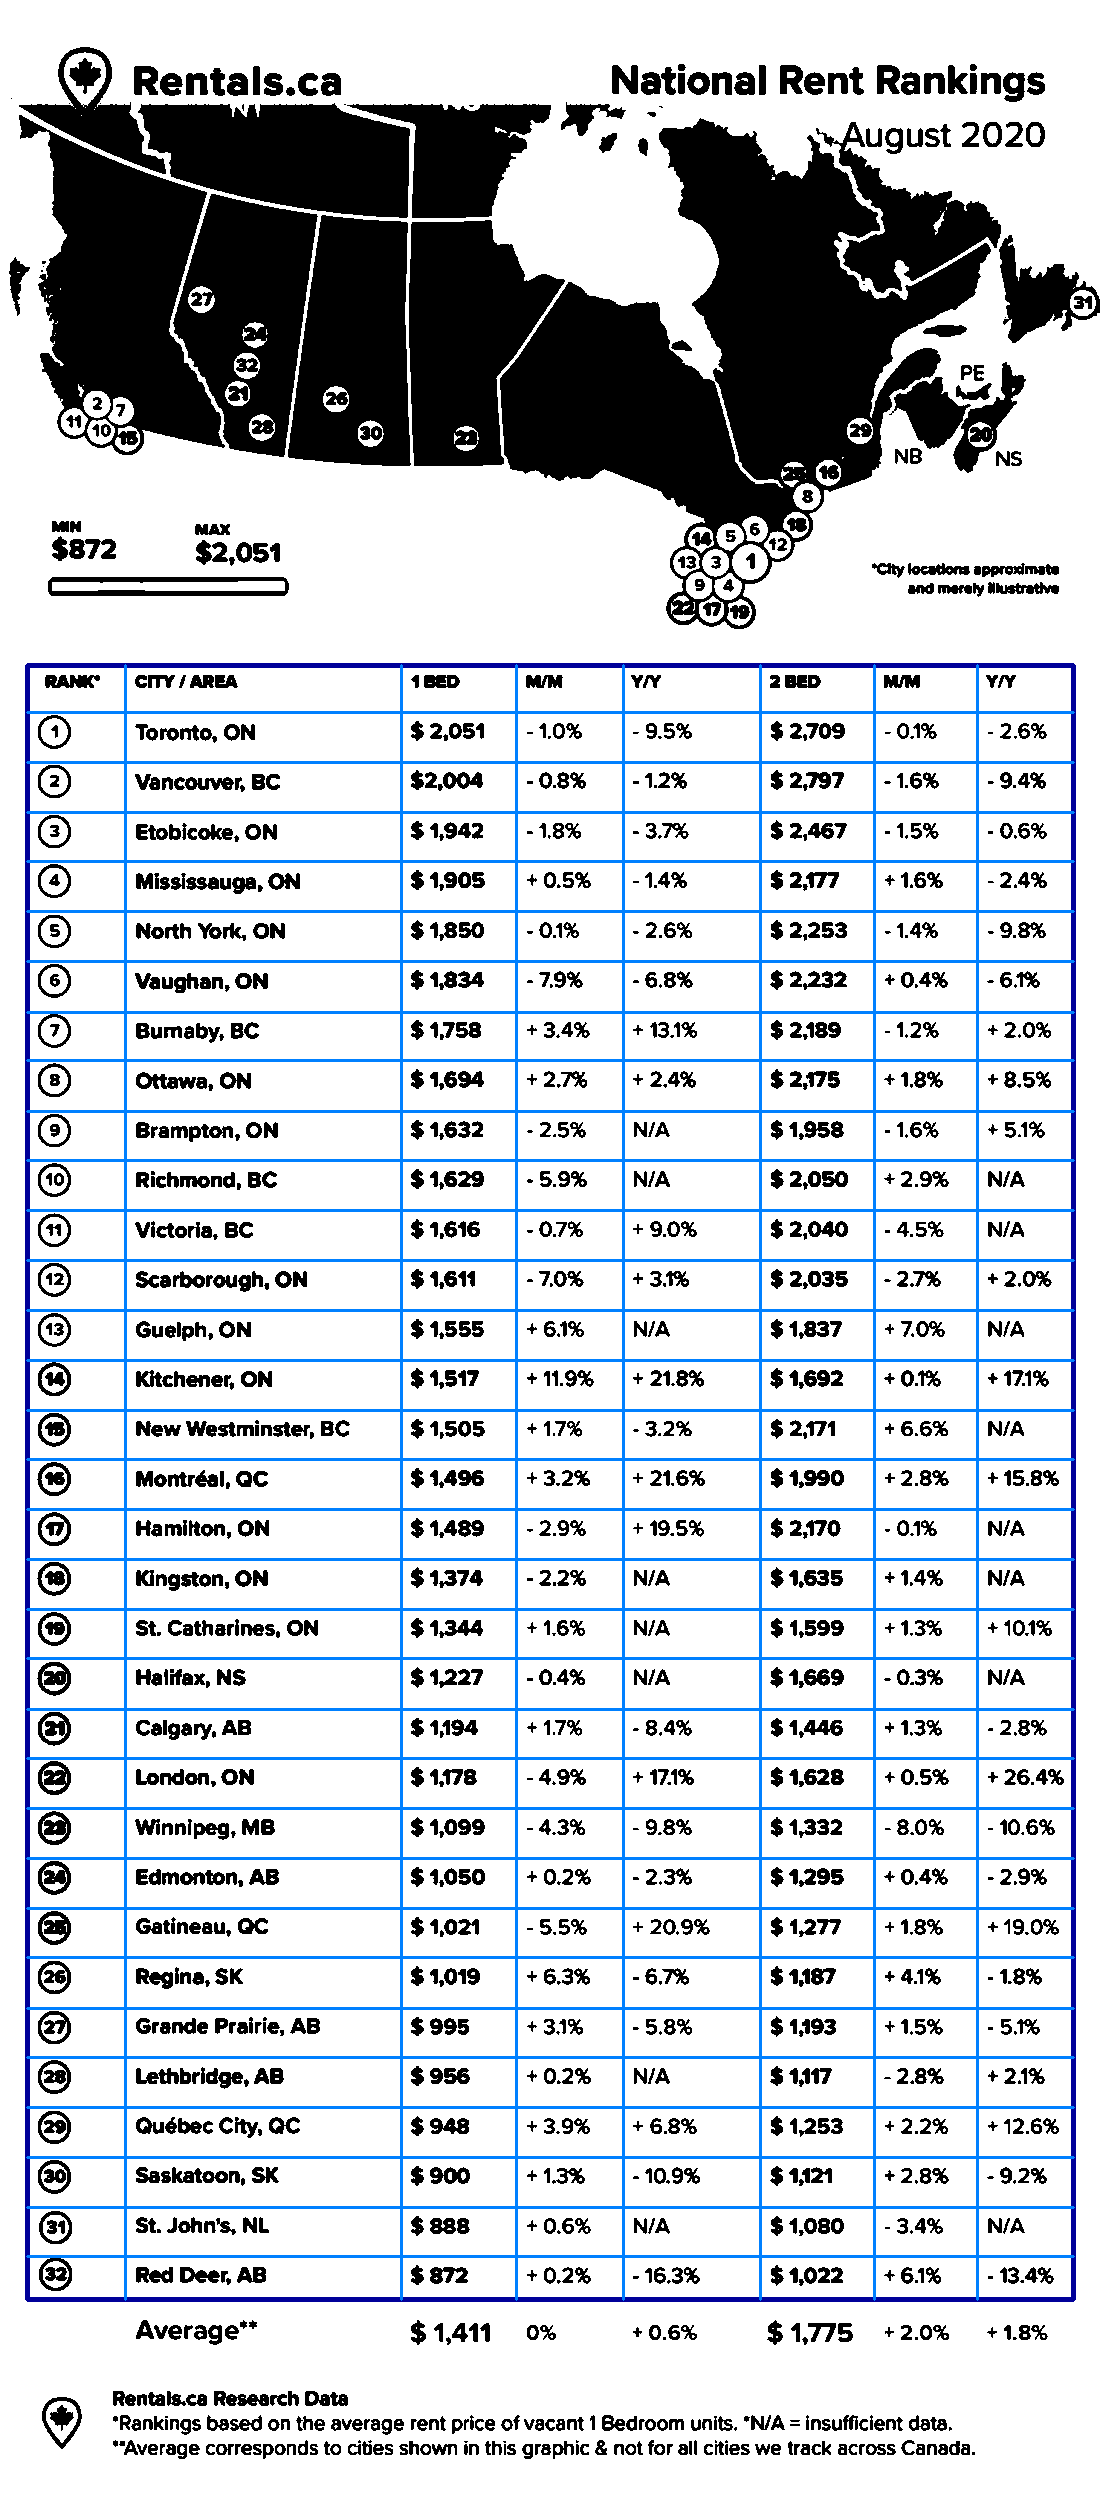

In [383]:
color_preprocessed = cv2.cvtColor(preprocessed, cv2.COLOR_GRAY2BGR)

border_color = [153, 0, 0] # dark blue
lines_color = [255, 128, 0] # mild blue

# Table corners
x_min = np.min(v_lines)
y_min = np.min(h_lines)
x_max = np.max(v_lines) + last_column_width
y_max = np.max(h_lines) + v_spacing + v_padding

# Drawing external borders
cv2.rectangle(color_preprocessed,
              (x_min, y_min),
              (x_max, y_max),
              color = border_color,
              thickness = 3)

for v_line in v_lines:
  if v_line != x_min:
    cv2.line(color_preprocessed,
            (v_line, y_min),
            (v_line, y_max),
             color = lines_color,
             thickness = 2)
    
for h_line in h_lines:
  if h_line != y_min:
    cv2.line(color_preprocessed,
             (x_min, h_line),
             (x_max, h_line),
             color = lines_color,
             thickness = 2)

cv2_imshow(color_preprocessed)

In [384]:
def get_table(image,
              new_line_thresh = 20,
              conf_thresh = 0,
              clust_dist_thresh = 25,
              min_cluster_size = 5,
              max_cluster_size = 50,
              return_conf = False):
  '''
  Extract table content from input preprocessed image.
  image: Preprocessed image to extract table content;
  new_line_thresh: Threshold to define when to consider a new line input.
    Defined as the minimum vertical distance between lines in pixels.
    Default = 20;
  conf_thresh: Threshold to erase low confidence OCR text. Integer between 0 and
    100. Default = 0;
  clust_dist_thresh: Agglomerative clustering distance thresold. Positive
    integer. Default = 25;
  min_cluster_size: Minimum Agglomerative cluster size. Positive integer.
    Default = 5;
  max_cluster_size: Maximum Agglomerative cluster size. Positive integer.
    Default = 50;
  return_conf: Whether to return confidence level with text content. Boolean.
    Default = False;
  Return df and colored image with bounding boxes.
  '''
  OCRdict = pytesseract.image_to_data(image,
                                      lang = 'eng',
                                      output_type = pytesseract.Output.DICT)

  # Initialize OCR text content and coordinates lists
  coords = []
  OCRtext = []

  # Initialize auxiliary lists and variables
  merged_text = []
  merged_width = 0
  prov_x = 0
  date = 'Date not found!'

  # Flags to manage text content
  within_table = 0
  new_line = 0
  is_city = 0
  is_province = 0

  # Iterate through OCR text from pytesseract output
  for i in range(0, len(OCRdict["text"])):
    # Exrtract bounding box and coordinates of the text region from OCR result
    x = OCRdict["left"][i]
    y = OCRdict["top"][i]
    # Storing previous text element "top" coordinate
    try:
      y_prev = OCRdict["top"][i-1]
    except:
      pass
    w = OCRdict["width"][i]
    h = OCRdict["height"][i]

    # Extract OCR text and confidence for thresholding
    text = OCRdict["text"][i]
    try:
      next_text = OCRdict["text"][i+1]
    except:
      pass
    conf = int(float(OCRdict["conf"][i]))

    # Initializing table on header first column 'rank'
    if "RANK" in text:
      within_table = 1

    # Extract month and year
    if not within_table:
      if (not re.match("[A-Z][a-z]*.", text) == None) and (not re.match("[0-9][0-9][0-9][0-9]", next_text) == None):
        date = f"{text} {next_text}"

    # Checking whether current text started a new line
    if (y - y_prev) > new_line_thresh:
      if within_table:
        new_line = 1

    # Checking whether current text is a city name and closing new line flag
    if new_line or is_city:
      if not re.match("[A-Z][a-z]*.", text) == None:
        is_city = 1
        # Storing provisory x coordinate for first city name component in line
        if new_line:
          prov_x += x
        new_line = 0
        # Merging current width
        merged_width += w
    
    # Checking whether current text is a province and closing new line flag
    if is_city:
      if len(text) == 2:
        is_province = 1
        is_city = 0
        new_line = 0
        # Resetting x coordinate to the first city name component found in line
        x = prov_x
        prov_x = 0
        merged_width += w

    if is_city:
      merged_text.append(text)
    
    # Overwitting current text with merged_text list to concatenate province and
    # complete city name
    if is_province:
      merged_text.append(text)
      text = ' '.join(merged_text)
      w = merged_width
      merged_width = 0
      merged_text = []
      is_province = 0

    # Ending table on 'grand total'
    if ("grand" in text.lower()) and ("total" in next_text.lower()):
      within_table = 0

    # Ending table on 'average'
    if "average" in text.lower():
      within_table = 0

    if conf < conf_thresh:
      text = '-'

    if within_table:
      if not is_city:
        coords.append((x, y, w, h))
        if return_conf:
          OCRtext.append(text + f" conf: {conf}")
        else:
          OCRtext.append(text)
    
  # Clustering on x coordinates to find columns
  # Instancing x coordinates with y = 0 to cluster
  xCoords = [(c[0], 0) for c in coords]

  # Hierarchical agglomerative clustering to the coordinates
  clustering = AgglomerativeClustering(n_clusters = None,
                                    affinity = "manhattan",
                                    linkage = "complete",
                                    distance_threshold = clust_dist_thresh)
  
  # Fitting AgglomerativeClustering to extracted x coordinates
  clustering.fit(xCoords)

  # Sorting clusters
  sortedClusters = []

  for label in np.unique(clustering.labels_):
    # Extract indices for the coordinates of current cluster
    idxs = np.where(clustering.labels_ == label)[0]

    # Condition acceptable cluster on mininmum size
    if (len(idxs) >= min_cluster_size) and (len(idxs) <= max_cluster_size):
      avg = np.average([coords[i][0] for i in idxs])
      sortedClusters.append((label, avg))

  # Sorting clusters by their average x-coordinate
  sortedClusters.sort(key = lambda x: x[1])
  df = pd.DataFrame()

  # Redefining test image as a colored OpenCV image
  color_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

  for (label, _) in sortedClusters:
    # Extract indices for the coordinates of current cluster
    idxs = np.where(clustering.labels_ == label)[0]

    # Y coordinates from the elements in the current cluster
    # Sort them top-to-bottom
    yCoords = [coords[i][1] for i in idxs]
    sortedIdxs = idxs[np.argsort(yCoords)]

    # Generate a random color for the cluster
    color = np.random.randint(0, 255, size = (3,), dtype = "int")
    color = [int(c) for c in color]

    # Loop over the sorted indices
    for i in sortedIdxs:
      # Extract bounding box coordinates and draw bounding box for current element
      (x, y, w, h) = coords[i]
      cv2.rectangle(color_img, (x, y), (x + w, y + h), color, 2)
    
    # Extract OCR text for the current column, then populate dataframe
    cols = [OCRtext[i].strip() for i in sortedIdxs]
    currentDF = pd.DataFrame({cols[0]: cols[1:]})

    # Concatenate initialized dataframe with currentDF
    df = pd.concat([df, currentDF], axis = 1)

  return date, df, color_img

In [ ]:
images[0]

'data/Rent_Report_Graphic__-_August_2022_2.width-720.png'

Processing input file: data/Rentals.ca_-_Rent_Report_-_January_2019.width-720-483x1024.png...
Image input dimensions: (483, 1024)
Image output dimensions: (1100, 2332)

January 2019
+----+-------------------+------------+------+------------+------+
|    | ar                | {BEDROOM   | MM   | 2BEDROOM   | MM   |
|----+-------------------+------------+------+------------+------|
|  0 | Toronto, ON       | $2135      | -    | $2.577     | -3%  |
|  1 | Missiesauga, ON   | $1,825     | -2%  | $2,2n      | 1%   |
|  2 | Vancouver, BC     | $1768      | -8%  | $2,541     | -3%  |
|  3 | Ottawa, ON        | $1,608     | +5%  | $1,959     | -3%  |
|  4 | York, ON          | $1,570     | +1%  | $2,214     | -2%  |
|  5 | Brampton, ON      | $1514      | -3%  | $1,681     | -5%  |
|  6 | Oshawe, ON        | $1,397     | :    | $1,464     | +2%  |
|  7 | Scarborough, ON   | $1,313     | 2%   | $1727      | 2%   |
|  8 | Calgary, AB       | $1,270     | +4%  | $1,448     | 5%   |
|  9 | Fort Mc

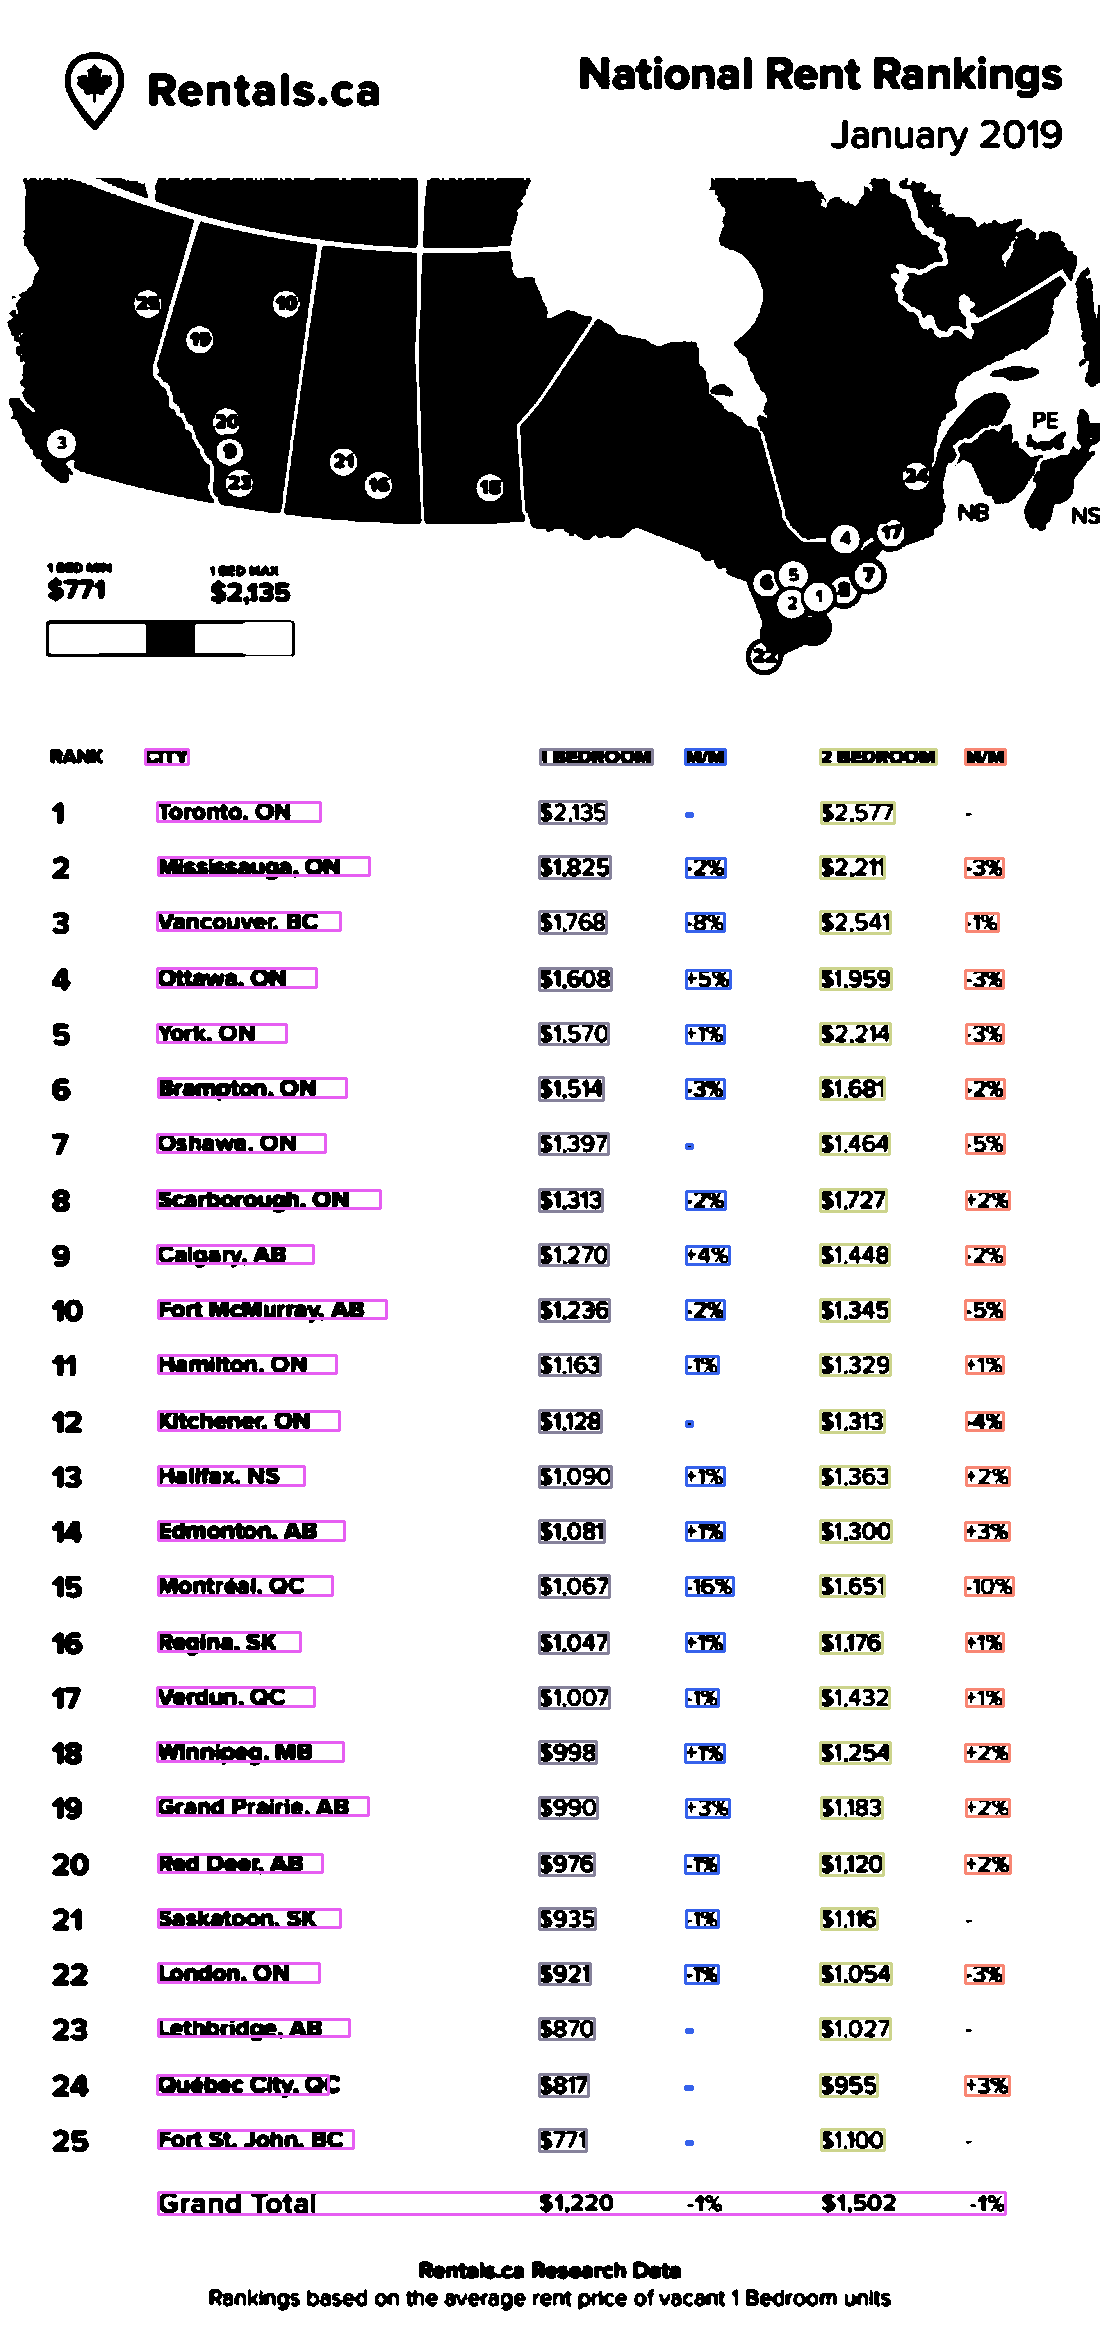

In [ ]:
preprocessed = preprocess(images[-1],
                          resize = preprocess_args['resize'],
                          grayscale = preprocess_args['grayscale'],
                          thresholding = preprocess_args['thresholding'],
                          thresh_value = preprocess_args['thresh_value'])

date, df, color_img = get_table(preprocessed)
df.fillna("", inplace=True)
print(date)
print(tabulate(df, headers="keys", tablefmt="psql"))
cv2_imshow(color_img)